In [ ]:
#import required libraries 
import gensim.downloader
from gensim.models import KeyedVectors
import gensim
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
import pandas as pd 
import re
import json
import numpy as np 
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot
import seaborn as sns
from nltk import FreqDist
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import numpy as np
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#I report here again the tokanization function because we will need them in the cells below
def sent_tokenizer(text):
    return re.findall(r".*?[.!\?]",text)

def word_tokenizer(sentence):
    punct = r"""([A-z])([,;:\?!\."'])"""
    temp_sentence =  re.sub(punct, r"\1 \2", sentence)
    toks = temp_sentence.split()
    temp_out =[]
    # splitting english possessive
    for tok in toks:
        if re.search(r"([A-z]+)’s?$", tok):
            temp_out.extend(re.sub(r"([A-z]+)(’s?)$", r"\1 \2", tok).split())
        else:
            temp_out.append(tok)
    return temp_out 

def my_tokenizer(text):
    import string 
    punct = string.punctuation 
    sentences = sent_tokenizer(text)
    tokenized_text = []
    for sent in sentences:
        if len(sent) > 1 and sent != []:
            tokens = word_tokenizer(sent)
            tokens_1 = [tok for tok in tokens if not tok in punct]
            tokenized_text.append(tokens_1)
    return tokenized_text

#### Consider the DEPRESSION corpus 

In [ ]:
depression = pd.read_csv('/content/drive/MyDrive/Computational_Linguistics_Project /depression_finale.csv', index_col= False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
deprex = [str(ele) for ele in depression['cleaned_text'][:]]

I need to normalize the words via a process called ***Lemmatization***.
It is used to trim words down to their root words. It returns a root word that is an actual language word.
I apply the lemmatizing process to our list object.

In [ ]:
lemmatizer = WordNetLemmatizer()

lemmatized_sentences = []
for article in deprex:
    lista_tokens = []
    for sent in my_tokenizer(article):
        for word in sent:
            lista_tokens.append(lemmatizer.lemmatize(word))
    lemmatized_sentences.append(lista_tokens)
            

Once I obtained a cleaned output, I would like to calculate each tokenized word's polarity scores using the ***VADER (Valence Aware Dictionary for Sentiment Reasoning) model***.

The polarity scores measure the positivity and negativity for each word. I am mostly interested in the compound score, which is normalized to be between -1 (most extreme negative sentiment) and +1 (most extreme positive sentiment). 

This provides a single unidimensional measure of sentiment for a given word.
I then stored this as a data frame object.

Moreover, I iterated through all the lemmatized sentences of single posts assigning each one as single key of a dictionary and providing as value another dictionary holding the sum of the negativity score calculated over all the words contained in that post and the lenght of the post itself. 

In [ ]:
nltk.download('vader_lexicon')
sia = SIA()
risultati = []
dizionario = {}

for i, sentence in enumerate(lemmatized_sentences[:5]):
    count = 0
    neg_score = 0
    pos_score = 0
    dizionario[f"article_{i}"] = {'len': 0, 'negative_score':0, 'delta_POS_NEG': 0}
    for word in sentence:
        count += 1
        pol_score = sia.polarity_scores(word)
        #print(pol_score)
        neg_score += int(pol_score['neg'])
        pos_score += int(pol_score['pos'])
        pol_score['words'] = word
        risultati.append(pol_score)
        delta = neg_score - pos_score
    dizionario[f"article_{i}"]['len'] = count
    dizionario[f"article_{i}"]['negative_score'] = neg_score
    dizionario[f"article_{i}"]['delta_POS_NEG'] = delta

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
dizionario

{'article_0': {'delta_POS_NEG': -4, 'len': 132, 'negative_score': 7},
 'article_1': {'delta_POS_NEG': -3, 'len': 67, 'negative_score': 3},
 'article_2': {'delta_POS_NEG': 6, 'len': 69, 'negative_score': 10},
 'article_3': {'delta_POS_NEG': 2, 'len': 38, 'negative_score': 5},
 'article_4': {'delta_POS_NEG': -10, 'len': 203, 'negative_score': 9}}

In [ ]:
#don't run again 
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []
dizio_sentiment = {}

for i, sentence in enumerate(lemmatized_sentences):
    count = 0
    neg_score = 0
    dizio_sentiment[f"article_{i}"] = {'len': 0, 'negative_score':0}
    for word in sentence:
        count += 1
        pol_score = sia.polarity_scores(word)
        neg_score += int(pol_score['neg'])
        pol_score['words'] = word
        results.append(pol_score)
    dizio_sentiment[f"article_{i}"]['len'] = count
    dizio_sentiment[f"article_{i}"]['negative_score'] = neg_score


In [ ]:
#save it to json file 
with open("/content/drive/MyDrive/Computational_Linguistics_Project /sentiment_depre.json", "w") as outfile:
    json.dump(dizio_sentiment, outfile)

In [ ]:
#open the file 
with open("/content/drive/MyDrive/Computational_Linguistics_Project /sentiment_depre.json", "r") as infile:
    dizio_sentiment = json.load(infile)

Here below I have been able to calculate the ***average length*** of the posts and the corresponding ***standard deviation.*** 
I did the same for the negativity score of the posts. 

In [ ]:
data1 = [ele['len'] for ele in dizio_sentiment.values()]
data2 = [ele['negative_score'] for ele in dizio_sentiment.values()]

# summarize
print('data1: mean=%.3f stdv=%.3f' % (mean(data1), std(data1)))
print('data2: mean=%.3f stdv=%.3f' % (mean(data2), std(data2)))


data1: mean=151.862 stdv=176.933
data2: mean=12.405 stdv=13.779


#### In the cell below you can find the code I used to obtain the scatterplot of our data points. 
***x-axis*** = lenght of posts
***y-axis*** = negativity score 

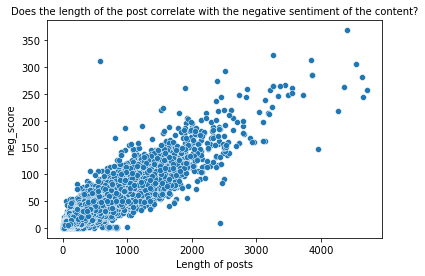

In [ ]:
length = np.array(data1)
N_score = np.array(data2)
  
# initialize data of lists.
data = {'length':length,
        'neg_score':N_score}
  
# Create DataFrame
dataf = pd.DataFrame(data)

#create csv with the values of length of posts and negative value
dataf.to_csv('/content/drive/MyDrive/Computational_Linguistics_Project /lunghezza_negativity_data.csv')
  
ax = sns.scatterplot(x='length', y="neg_score", data=dataf)
ax.set_title("Does the length of the post correlate with the negative sentiment of the content?", fontdict= { 'fontsize': 10, 'fontweight':'normal'})
ax.set_xlabel("Length of posts");
plt.savefig('correlation.png')

**corrcoef()** returns the correlation matrix, which is a two-dimensional array with the correlation coefficients. Here’s a simplified version of the correlation matrix you just created:

In [ ]:
#Pearson's correlation coefficient 
Pearson = np.corrcoef(length, N_score)
Pearson[0, 1]

0.914406001233707

In [ ]:
pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df

,neg,neu,pos,compound,words
0,0.0,1.0,0.0,0.0000,you
1,0.0,1.0,0.0,0.0000,ever
2,0.0,1.0,0.0,0.0000,maintained
3,1.0,0.0,0.0,-0.4767,poor
4,0.0,0.0,1.0,0.4404,friendship
...,...,...,...,...,...
46300793,1.0,0.0,0.0,-0.2023,complaining
46300794,0.0,1.0,0.0,0.0000,though
46300795,0.0,0.0,0.0,0.0000,i
46300796,0.0,1.0,0.0,0.0000,wondering


In [ ]:
df = df.drop_duplicates()

Next, I added a new column ***label*** which filters the words based on the compound score and our criteria for categorizing them. In our case, I used a compound score of +- 0.10 to discern between positive, negative and neutral words.

In [ ]:
#Addition of a label for each word 
df['label'] = 0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1
df.head()

/var/folders/vv/l7jlyypd0n9d_2f1phl7rl_80000gn/T/ipykernel_24033/3496330288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = 0
/usr/local/anaconda3/cling/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,neg,neu,pos,compound,words,label
0,0.0,1.0,0.0,0.0000,you,0
1,0.0,1.0,0.0,0.0000,ever,0
2,0.0,1.0,0.0,0.0000,maintained,0
3,1.0,0.0,0.0,-0.4767,poor,-1
4,0.0,0.0,1.0,0.4404,friendship,1


In [ ]:
#representation of sentiment results
df['label'].value_counts()

 0    151156
-1      2473
 1      1743
Name: label, dtype: int64

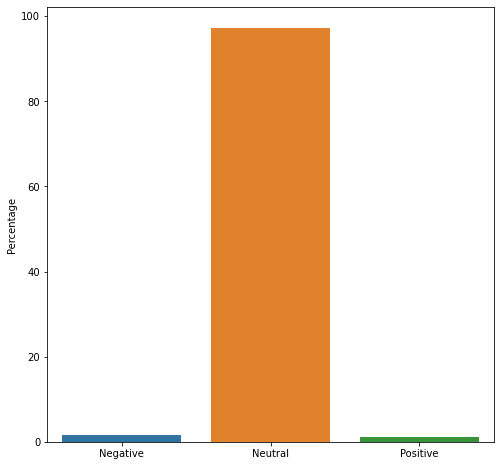

In [ ]:
#distribution of sentiment results 
fig, ax = plt.subplots(figsize = (8,8))

counts = df.label.value_counts(normalize = True )*100

sns.barplot(x = counts.index, y = counts, ax = ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel('Percentage')

plt.show()

In [ ]:
##simple visualizations 
positive_words = list(df.loc[df['label'] == 1].words)

In [ ]:
positive_frequency = FreqDist(positive_words)
pos_freq = positive_frequency.most_common(20)
pos_freq

[('friendship', 1),
 ('friend', 1),
 ('like', 1),
 ('improved', 1),
 ('beneficial', 1),
 ('positive', 1),
 ('feeling', 1),
 ('happiness', 1),
 ('wishing', 1),
 ('slap', 1),
 ('happier', 1),
 ('fine', 1),
 ('helping', 1),
 ('help', 1),
 ('relief', 1),
 ('peculiar', 1),
 ('hope', 1),
 ('dream', 1),
 ('value', 1),
 ('emotional', 1)]

In [ ]:
negative_words = list(df.loc[df['label'] == -1].words)

In [ ]:
negative_frequency = FreqDist(negative_words)
neg_freq = negative_frequency.most_common(10)
neg_freq

[('poor', 1),
 ('stuck', 1),
 ('frustrating', 1),
 ('problem', 1),
 ('depression', 1),
 ('worried', 1),
 ('sad', 1),
 ('stupid', 1),
 ('sadness', 1),
 ('suffer', 1)]

In [ ]:
#Visualize them via WordCloud
Pos_words = [str(p) for p in pos_freq]
pos_words_string = ' , '.join(Pos_words)


In [ ]:
Neg_words = [str(p) for p in neg_freq]
neg_words_string = ' , '.join(Neg_words)

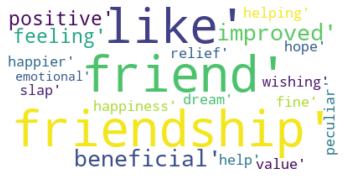

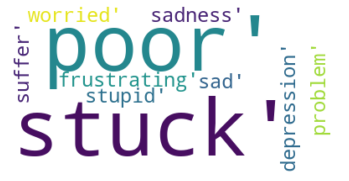

In [ ]:
#create and generate a word cloud image
wordcloud_positive = WordCloud(background_color = 'white').generate(pos_words_string)
wordcloud_negative = WordCloud(background_color = 'white').generate(neg_words_string)
plt.imshow(wordcloud_positive, interpolation = 'bilinear')
plt.axis('off')
plt.show()

plt.imshow(wordcloud_negative, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
from PIL import Image
head = np.array(Image.open("/content/drive/MyDrive/Computational_Linguistics_Project /brain.jpeg"))

In [ ]:
def transform_format(val):
    val = val.any()
    if val == 0:
        return 255
    else:
        return val

In [ ]:
transformed_head_mask = np.ndarray((head.shape[0],head.shape[1]), np.int32)

for i in range(len(head)):
    transformed_head_mask[i] = list(map(transform_format, head[i]))

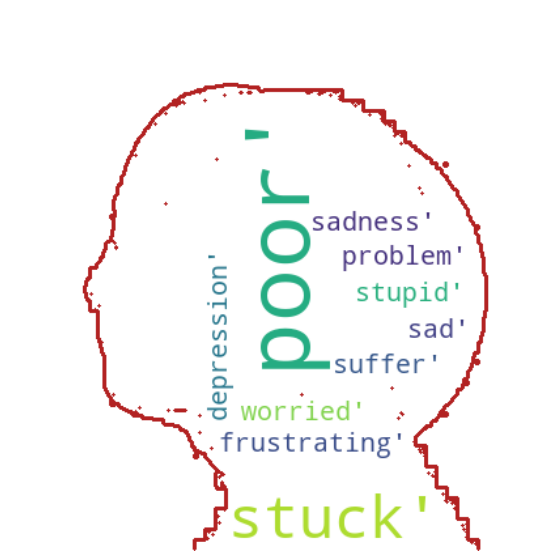

In [ ]:
stopwords = set(STOPWORDS)
wc = WordCloud(background_color="white", max_words=200, mask=transformed_head_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc.generate(neg_words_string)

# store to file
wc.to_file("testa_deprex.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


See if there exists a larger distance between 1st  person singular pronoun and positive words (or viceversa more similarity between 1st person singular pronoun and negative words)


In [ ]:
depressed_model = Word2Vec.load("/content/drive/MyDrive/Computational_Linguistics_Project /word_embedding_models/depressed.model")

In [ ]:
totale_neg = 0
totale_pos = 0

for index, row in df.iterrows():
    parola = row['words']
    label = row['label']
    try:
        if label == -1:
        
            if totale_neg == 0:
                totale_neg += 1
                vettore_somma_negative = np.array(depressed_model.wv[parola])
            else:
                totale_neg += 1    
                output = np.array(depressed_model.wv[parola])
                vettore_somma_negative += output
                #print(vettore_somma_negative)

        if label == 1:

            if totale_pos == 0:
                totale_pos += 1
                vettore_somma_positive = np.array(depressed_model.wv[parola])
            else:
                totale_pos += 1    
                output = np.array(depressed_model.wv[parola])
                vettore_somma_positive += output
                #print(vettore_somma_positive)
            
    except:
        pass

In [ ]:
#compute the centroid
centro_negative = vettore_somma_negative/totale_neg
centro_positive = vettore_somma_positive/totale_pos

In [ ]:
#vector of first singular person pronoun
io = depressed_model.wv['i']

In [ ]:
#I define the cosine similarity function 
def cosine_similarity(a, b):
    nominator = np.dot(a, b)
    
    a_norm = np.sqrt(np.sum(a**2))
    b_norm = np.sqrt(np.sum(b**2))
    
    denominator = a_norm * b_norm
    
    cosine_similarity = nominator / denominator
    
    return cosine_similarity

In [ ]:
#this value should be higher than the following one, meaning that the distance between negative words and I in depressed people
#is smaller than the distance between positive words and I.
cosine_similarity(centro_negative, io)

0.51051927

In [ ]:
cosine_similarity(centro_positive, io)

0.49987406